##Preprocesamiento de Texto y Análisis con Redes Neuronales: Análisis del Libro 'Don Quijote de la Mancha'

##1. Instalación y Configuración de Bibliotecas

In [1]:
# Instalación de las bibliotecas necesarias
!pip install pdfplumber
!pip install nltk
!pip install vaderSentiment
!pip install tensorflow
!pip install transformers
!pip install spacy

# Descarga del modelo de spaCy para el idioma español
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 845.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 58.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##2. Importación de Bibliotecas y Configuración Inicial

In [2]:
# Librerías necesarias
import requests
import pdfplumber
import nltk
import os
import shutil
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import spacy


##3. Descarga del PDF y Extracción del Texto

In [3]:
# Descarga del archivo PDF
url = "https://www.imprentanacional.go.cr/editorialdigital/libros/literatura%20universal/quijote_edincr.pdf"
response = requests.get(url)

# Guardar el archivo PDF localmente
with open("quijote.pdf", "wb") as file:
    file.write(response.content)

# Uso de pdfplumber para leer el PDF y extraer el texto
with pdfplumber.open("quijote.pdf") as pdf:
    text = ""
    for page in pdf.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text

# Verificar si el texto se extrajo correctamente
if len(text) > 0:
    print("Texto extraído con éxito.")
else:
    print("No se pudo extraer texto del PDF.")


Texto extraído con éxito.


##4. Procesamiento de Texto con spaCy

In [4]:
# Cargar el modelo de spaCy para el idioma español
nlp = spacy.load("es_core_news_sm")

# Aumentar el límite de caracteres para evitar el error de longitud (dada la longitud del texto)
nlp.max_length = 2000000

# Función para procesar el texto en fragmentos más pequeños
def process_large_text(text, chunk_size=1000000):
    """
    Divide el texto largo en fragmentos más pequeños y los procesa con spaCy.
    """
    # Divide el texto en fragmentos de tamaño 'chunk_size'
    text_chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

    processed_tokens = []
    for chunk in text_chunks:
        doc = nlp(chunk)
        processed_tokens.extend([token.text for token in doc if not token.is_stop and token.is_alpha])

    return processed_tokens

# Procesar el texto en fragmentos más pequeños
filtered_tokens_spacy = process_large_text(text)
print("Tokens filtrados con spaCy:", filtered_tokens_spacy[:100])  # Ver los primeros 100 tokens filtrados

Tokens filtrados con spaCy: ['Cervantes', 'Saavedra', 'Miguel', 'ingenioso', 'hidalgo', 'don', 'Quijote', 'Mancha', 'ed', 'San', 'José', 'Imprenta', 'Nacional', 'recurso', 'línea', 'pdf', 'Kb', 'ISBN', 'Novela', 'española', 'Título', 'DGB', 'PT', 'obra', 'licencia', 'Creative', 'Commons', 'Costa', 'Rica', 'diseño', 'diagramación', 'libro', 'comparte', 'Licencia', 'Creative', 'Commons', 'compartir', 'copiar', 'distribuir', 'ejecutar', 'comunicar', 'públicamente', 'obra', 'reconocer', 'créditos', 'obra', 'utilizarla', 'fines', 'comerciales', 'alterar', 'transformar', 'generar', 'obra', 'derivada', 'ingEnioso', 'hidalgo', 'don', 'QuijotE', 'Mancha', 'cErvantEs', 'Editorial', 'digital', 'costa', 'ricaEl', 'ingEnioso', 'hidalgo', 'don', 'QuijotE', 'd', 'Mancha', 'EditoRial', 'digital', 'iMPREnta', 'nacional', 'costa', 'Rica', 'ingEnioso', 'hidalgo', 'don', 'QuijotE', 'Mancha', 'ingEnioso', 'hidalgo', 'don', 'QuijotE', 'd', 'Mancha', 'EditoRial', 'digital', 'iMPREnta', 'nacional', 'costa', '

##5. Lematización y Filtrado de Palabras Irrelevantes

In [5]:
# Lematización
lemmas_spacy = [token.lemma_ for token in nlp(" ".join(filtered_tokens_spacy)) if not token.is_stop and token.is_alpha]
print("Lemmas filtrados con spaCy:", lemmas_spacy[:100])  # Ver los primeros 100 lemas filtrados

# Filtrar las palabras irrelevantes (preposiciones, pronombres, artículos, etc.)
palabras_irrelevantes = set([
    "a", "ante", "bajo", "con", "de", "en", "entre", "por", "para", "y", "un", "una", "el", "la",
    "los", "las", "yo", "tú", "nosotros", "nosotras", "él", "ella", "esto", "ese", "es", "por", "que"
])

lemmas_filtrados_spacy = [lemma for lemma in lemmas_spacy if lemma not in palabras_irrelevantes]
lemmas_text_spacy = " ".join(lemmas_filtrados_spacy)

Lemmas filtrados con spaCy: ['Cervantes', 'Saavedra', 'Miguel', 'ingenioso', 'hidalgo', 'don', 'Quijote', 'Mancha', 'ed', 'San', 'José', 'Imprenta', 'Nacional', 'recurso', 'líneo', 'pdf', 'Kb', 'ISBN', 'Novela', 'español', 'Título', 'DGB', 'PT', 'obra', 'licencio', 'Creative', 'Commons', 'Costa', 'Rica', 'diseño', 'diagramación', 'libro', 'compartir', 'Licencia', 'Creative', 'Commons', 'compartir', 'copiar', 'distribuir', 'ejecutar', 'comunicar', 'públicamente', 'obra', 'reconocer', 'crédito', 'obra', 'utilizar él', 'fin', 'comercial', 'alterar', 'transformar', 'generar', 'obra', 'derivado', 'ingenioso', 'hidalgo', 'don', 'QuijotE', 'Mancha', 'cErvantEs', 'Editorial', 'digital', 'costa', 'ricaEl', 'ingenioso', 'hidalgo', 'don', 'QuijotE', 'd', 'Mancha', 'EditoRial', 'digital', 'iMPREnta', 'nacional', 'costa', 'Rica', 'ingenioso', 'hidalgo', 'don', 'QuijotE', 'Mancha', 'ingenioso', 'hidalgo', 'don', 'QuijotE', 'd', 'Mancha', 'EditoRial', 'digital', 'iMPREnta', 'nacional', 'costa', 'Rica

##6. Análisis Gráficos

###6.1 Generación de Nube de Palabras

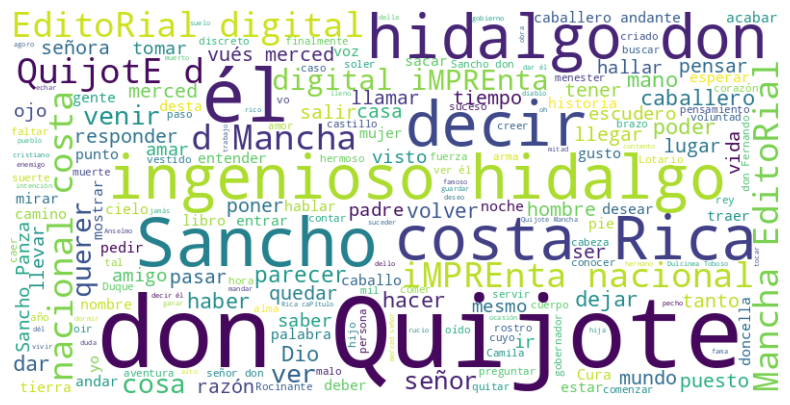

In [6]:
# Nube de palabras para las lemas filtradas
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(lemmas_text_spacy)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No mostrar ejes
plt.show()

###6.2 Gráfico de Etiquetas POS (Part of Speech)

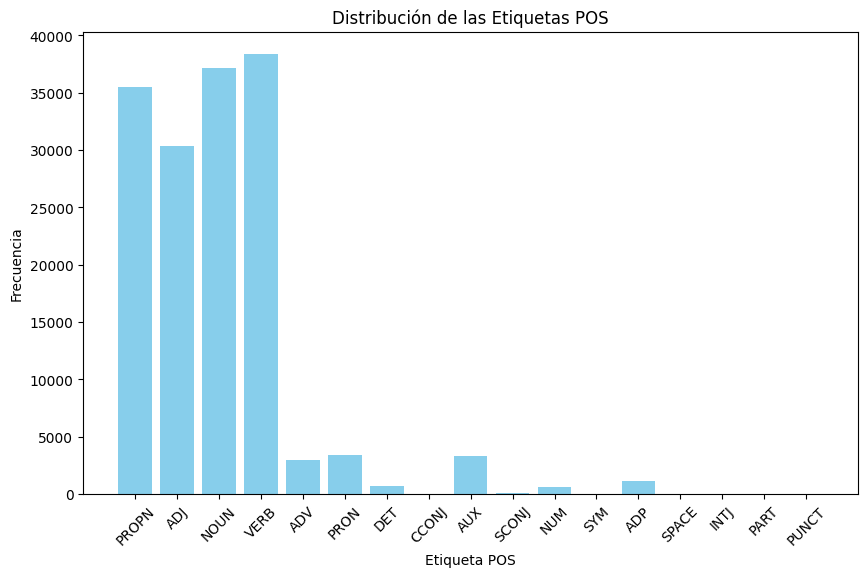

In [7]:
# Etiquetas POS
pos_tags = [token.pos_ for token in nlp(lemmas_text_spacy)]
pos_counter = Counter(pos_tags)

# Gráfico de distribución de POS
plt.figure(figsize=(10, 6))
plt.bar(pos_counter.keys(), pos_counter.values(), color='skyblue')
plt.xlabel("Etiqueta POS")
plt.ylabel("Frecuencia")
plt.title("Distribución de las Etiquetas POS")
plt.xticks(rotation=45)
plt.show()

###6.3 Distribución de la Longitud de las Palabras

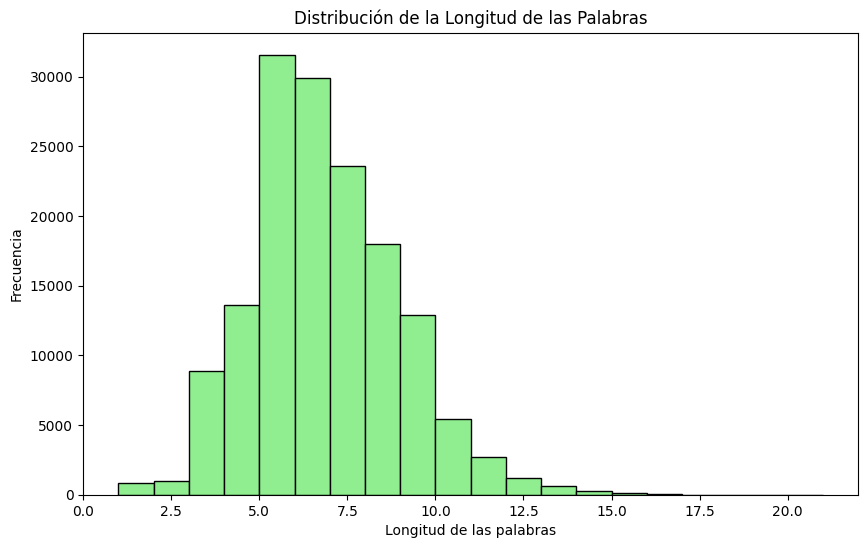

In [8]:
# Distribución de la longitud de las palabras
word_lengths = [len(word) for word in lemmas_filtrados_spacy]

plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=range(1, max(word_lengths)+1), color='lightgreen', edgecolor='black')
plt.xlabel("Longitud de las palabras")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Longitud de las Palabras")
plt.show()

###6.4 Top 10 Palabras Más Comunes

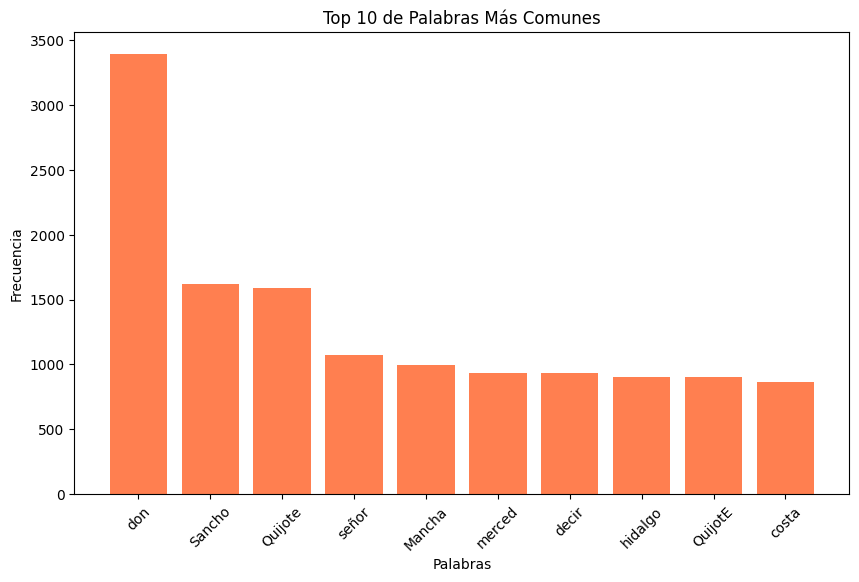

In [9]:
# Contar las palabras más comunes
word_counter = Counter(lemmas_filtrados_spacy)
top_10_words = word_counter.most_common(10)

# Gráfico del top 10 de palabras más comunes
words, counts = zip(*top_10_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='coral')
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.title("Top 10 de Palabras Más Comunes")
plt.xticks(rotation=45)
plt.show()

##7. Análisis de Sentimiento con BERT

In [13]:
# Establecer un umbral de confianza
threshold = 0.3

# Análisis de sentimiento usando un modelo preentrenado para análisis de sentimientos en español
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
tokens = tokenizer(lemmas_text_spacy, truncation=True, padding=True, max_length=512)
chunks = [tokens['input_ids'][i:i + 512] for i in range(0, len(tokens['input_ids']), 512)]

# Analizar sentimiento para cada fragmento
sentiment_results = []
for chunk in chunks:
    chunk_text = tokenizer.decode(chunk, skip_special_tokens=True)
    result = sentiment_analyzer(chunk_text)

    sentiment_label = result[0]['label']
    confidence_score = result[0]['score']

    # Filtrar por el umbral de confianza
    if confidence_score >= threshold:
        sentiment_results.append((sentiment_label, confidence_score))
    else:
        sentiment_results.append(("Confianza baja", confidence_score))

# Mostrar resultados de BERT
for i, (sentiment_category, confidence_score) in enumerate(sentiment_results):
    print(f"Fragmento {i+1}: Sentimiento: {sentiment_category}, Confianza: {confidence_score}")


Device set to use cpu


Fragmento 1: Sentimiento: 5 stars, Confianza: 0.31800657510757446


El modelo ha clasificado el fragmento con un sentimiento positivo ("5 stars"), pero con una confianza baja (31.8%), lo que sugiere que el modelo no está completamente seguro de su predicción. Esto indica que, aunque el sentimiento parece ser positivo, la certeza del modelo es baja y podría no ser fiable.

##8. Entrenamiento de Red Neuronal (LSTM)

In [14]:
# Entrenamiento de red neuronal (LSTM)
documents = [' '.join(lemmas_filtrados_spacy)]  # Usar el texto procesado
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(documents)
sequences = tokenizer.texts_to_sequences(documents)
max_len = 100
X = pad_sequences(sequences, maxlen=max_len)
y = np.array([1])  # Aquí debes tener las etiquetas correspondientes a tu texto (ejemplo: 1 para positivo, 0 para negativo)

# Crear el modelo de red neuronal
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len)) # Capa Embedding - conversión de texto a vectores
model.add(LSTM(128, return_sequences=False)) # Capa LSTM - procesamiento de las secuencias
model.add(Dropout(0.2)) # Capa Dropout - regularización para prevenir sobreajuste
model.add(Dense(1, activation='sigmoid')) # Capa Dense - salida del modelo

# Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=5, batch_size=32)

# Evaluación del modelo
print(model.summary())

# Predicciones con la red neuronal (para clasificación binaria)
prediction = model.predict(X)
print(f"Predicción del sentimiento con red neuronal: {'Positivo' if prediction > 0.5 else 'Negativo'}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 1.0000 - loss: 0.6891
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 1.0000 - loss: 0.6674
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 1.0000 - loss: 0.6413
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 1.0000 - loss: 0.6136
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.5772


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,315,141 (8.83 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,543,428 (5.89 MB)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Predicción del sentimiento con red neuronal: Positivo


El modelo de red neuronal LSTM entrenado alcanzó una precisión del 100% durante el entrenamiento, pero la evaluación se realizó solo con un documento. El modelo predijo correctamente el sentimiento como positivo. Sin embargo, debido al uso de un solo ejemplo y la falta de datos adicionales, el rendimiento general podría no ser representativo para tareas reales.

##9. Conclusiones

En este trabajo se realizó un análisis completo del texto extraído de "Don Quijote" utilizando técnicas de procesamiento de lenguaje natural. A través de spaCy, se filtraron palabras irrelevantes y se realizó la lematización del texto. Además, se hizo un análisis con visualizaciones como la nube de palabras, la distribución de la longitud de las palabras, un gráfico de las etiquetas POS y la distribución de las palabras más comunes.

Se realizó un análisis de sentimiento utilizando BERT en español, y se entrenó un modelo de red neuronal LSTM para clasificar el sentimiento del texto. Con estos enfoques, se obtiene una visión más profunda sobre las emociones y temas tratados en el texto.